# MD Folding Simulation of the TRP Cage Protein with Heavy-H (Local)

This is an attempt to fold the TRP Cage protein using a MD simulation. The simulation will be run with explicit water and at 325K which *should* allow the full configuration space of the protein to be explored. The protein is initially generated using pymol by adding a single amino acid residue one at a time. This creates a linear backbone that should be ready for folding. The hydrogen atoms are increased in weight to around 4 AMU to allow the timestep in the simulation to be larger, and thus allows for faster simulation runs. This should not affect the final folded configuration.

The computationally expensive parts of this simulation will be run on Artemis (the HPC at Sydney University) and as such there is a [second related notebook](./folding_study_artemis.ipynb) that contains the commands run on Artemis.

---
To begin with we will convert our PDB file into a gromacs format. In this step we specify the water model that we will be using (-water spce) and also increase the weight of all of the hydrogen atoms to 4 (-heavyh). The -ignh ignores the specification of the hydrogen atoms in the PDB file and regenerates them, this is required if the hydrogen naming convention in the PDB file does not match what is expected by gromacs. 

In [19]:
%%bash
module load gromacs

gmx pdb2gmx -f trp_cage_linear.pdb -o trp_cage_processed.gro -ignh -heavyh -water spce -ff oplsaa 2>/dev/null


Using the Oplsaa force field in directory oplsaa.ff

Reading trp_cage_linear.pdb...
Read 153 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 153 atoms

  chain  #res #atoms
  1 ' '    20    153  

Reading residue database... (oplsaa)
Processing chain 1 (153 atoms, 20 residues)
Identified residue ASN2 as a starting terminus.
Identified residue SER21 as a ending terminus.
Start terminus ASN-2: NH3+
End terminus SER-21: COO-
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: trp_cage_linear.pdb.
The Oplsaa force field and the spce water model are used.
		--------- ETON ESAELP ------------


---
Next we will adjust the box size and then add the water molecules. The box chosen will be cubic as this will suit the globular folded protein structure. However when the protein is in its initial linear form, the cubic box will end up being significantly oversized. This will result in there being a large number of water molecules introduced during the solvation step which will in-turn cause the simulation to run slower than necessary.

To deal with this situation, we will initially solvate the larger box with a large number of water molecules and run the simulation for ~10 nS. After this initial run, the protein should have shifted to a more globular form. At this point we will strip out the solvent, correct the box size to a smaller box and then resolvate. The simulation will then be able to run with the lower solvent load for the remainder of the simulation.

In [20]:
%%bash
module load gromacs

gmx editconf -f trp_cage_processed.gro -o trp_cage_newbox.gro -c -d 1.0 -bt cubic 2>/dev/null
gmx solvate -cp trp_cage_newbox.gro -cs spc216.gro -o trp_cage_solv.gro -p topol.top 2>/dev/null

Read 304 atoms
Volume: 36.3039 nm^3, corresponds to roughly 16300 electrons
No velocities found
    system size :  4.702  3.644  2.119 (nm)
    diameter    :  5.546               (nm)
    center      :  2.329  1.321  0.388 (nm)
    box vectors :  4.702  3.643  2.119 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :  36.30               (nm^3)
    shift       :  1.444  2.452  3.385 (nm)
new center      :  3.773  3.773  3.773 (nm)
new box vectors :  7.546  7.546  7.546 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  : 429.69               (nm^3)

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may b

---
Our protein has a net charge of 1 (which can be seen in the topol.top file). This charge needs to be neutralised with a counter-ion. In this next step we replace one of the water molecules with a chlorine ion to neutralise the solution. The configuratio file required here is just the same as the energy minimisation file that we will need in the next step.

**Warning - if you run this step more than once, it will keep adding chlorine ions to the system each time!!!** 

In [21]:
%%file em.mdp
; Parameters describing what to do, when to stop and what to save
integrator  = steep     ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0    ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01      ; Energy step size
nsteps      = 50000     ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = PME       ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions (yes/no)

Overwriting em.mdp


In [22]:
%%bash
module load gromacs

gmx grompp -f em.mdp -c trp_cage_solv.gro -p topol.top -o ions.tpr 2>/dev/null
gmx genion -s ions.tpr -o trp_cage_solv_ions.gro -p topol.top -pname NA -nname CL -nn 1 <<< $'13\n' 2>/dev/null

Analysing residue names:
There are:    20    Protein residues
There are: 13482      Water residues
Analysing Protein...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 64x64x64, spacing 0.118 0.118 0.118
This run will generate roughly 3 Mb of data
Will try to add 0 NA ions and 1 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 1 solute molecules in topology file (topol.top)  by 0 NA and 1 CL ions.


---
The next step is to relax the system (protein and solvent). This is done by using a steepest descent minimisation. This step helps to ensure that the system will not blow up when the MD runs start.

In [24]:
%%bash
module load gromacs

gmx grompp -f em.mdp -c trp_cage_solv_ions.gro -p topol.top -o em.tpr 2> /dev/null
gmx mdrun -v -deffnm em 2> /dev/null

Analysing residue names:
There are:    20    Protein residues
There are: 13481      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 64x64x64, spacing 0.118 0.118 0.118
This run will generate roughly 3 Mb of data


In [26]:
%%bash
module load gromacs

gmx energy -f em.edr -o em.xvg <<< $'10\n' 2> /dev/null


Statistics over 764 steps [ 0.0000 through 763.0000 ps ], 1 data sets
All statistics are over 605 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                   -692555       9900    23124.4   -65855.1  (kJ/mol)


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from helpers.GromacsHelpers import *
%matplotlib inline

ImportError: No module named matplotlib

/opt/conda3/4.2.12/envs/md-gmx-2016.2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


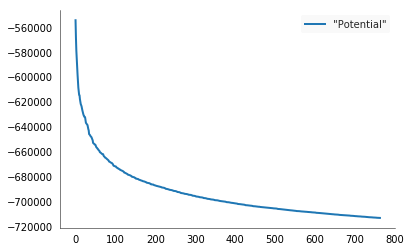

In [37]:
plotFigure("em.xvg")

In [46]:
%%bash
module load gromacs

gmx editconf -f em.gro -o em.pdb 2>/dev/null

Read 40748 atoms
Volume: 429.687 nm^3, corresponds to roughly 193300 electrons
No velocities found


In [66]:
pymolPlotStructure("em.pdb")

ImportError: cannot import name invocation